In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate , train_test_split , StratifiedShuffleSplit,StratifiedKFold,cross_val_score
from sklearn import linear_model, metrics
from sklearn.linear_model import SGDClassifier as SGD
from sklearn.preprocessing import StandardScaler,LabelEncoder

In [2]:
#В первую очередь, давайте проверим, что нет пропущенных значений:

path = 'train.csv'

df = pd.read_csv('train.csv')
for c in df.columns:
    no_missing = df[c].isnull().sum()
    if no_missing > 0:
        print('%s \n %s' %(c,no_missing))
    else:
        print('%s \nNo missing values \n' % (c))

#Датасет полностью корректный, пропущенных значений нет

age 
No missing values 

job 
No missing values 

marital 
No missing values 

education 
No missing values 

default 
No missing values 

housing 
No missing values 

loan 
No missing values 

contact 
No missing values 

month 
No missing values 

day_of_week 
No missing values 

duration 
No missing values 

campaign 
No missing values 

pdays 
No missing values 

previous 
No missing values 

poutcome 
No missing values 

emp.var.rate 
No missing values 

cons.price.idx 
No missing values 

cons.conf.idx 
No missing values 

euribor3m 
No missing values 

nr.employed 
No missing values 

y 
No missing values 



In [3]:
#Я тестировал различные конфигурации параметров, данная конфигурация показала один из лучших результатов.
columns = ['age',
           'job',
           'marital',
           #'education',
           #'default',
           'housing',
           'loan',
           'contact',
           'month',
           'day_of_week',
           'duration',
           'campaign',
           'pdays',
           'previous',
           'poutcome',
           'emp.var.rate',
           'cons.price.idx',
           'cons.conf.idx',
           'euribor3m',
           'nr.employed',
           'y']

In [4]:
df = df[columns]
df

,age,job,marital,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3217,47,services,married,no,no,cellular,aug,fri,130,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
3218,55,blue-collar,married,no,no,cellular,jul,tue,232,4,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no
3219,46,blue-collar,married,yes,no,telephone,may,wed,196,2,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
3220,24,student,single,yes,no,cellular,apr,thu,88,1,999,0,nonexistent,-1.8,93.075,-47.1,1.365,5099.1,no


In [5]:
text_columns = ['job',
           'marital',
           'housing',
           'loan',
           'contact',
           'education',
           'default',
           'month',
           'day_of_week',
           'pdays',
           'previous',
           'poutcome',
           'emp.var.rate',
           'cons.price.idx',
           'cons.conf.idx',
           'euribor3m',
           'nr.employed',
           'y']

In [6]:
scaler = StandardScaler()
le = LabelEncoder()

In [7]:
def get_data(df):
    
    #для того, чтобы преобразовать текстовые значения в числовые используем LabelEncoder
    for column in text_columns:
        if (column not in columns):
            continue
        df[column] = le.fit_transform(df[column])
    
    y = df.pop('y').to_numpy()

    #Нормируем значения, используя StandardScaler. Он вычитывает среднее и делит на среднеквадратичное отклонение
    scaler.fit(df)
    x = scaler.transform(df)
    return x,y

In [8]:
x,y = get_data(df)

no : 2860/3222 (88.8%)
yes : 362/3222 (11.2%)


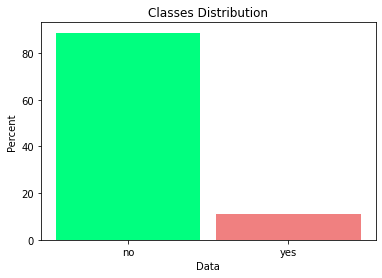

In [9]:
#Давайте посмотрим, насколько сбалансирован наш датасет

n_samples = x.shape[0]
distribution= []

#посчитаем процентное соотношение класссов

for c in range(2):
    n_examples = len(y[y==c])
    
    percent = n_examples / n_samples * 100
    distribution.append(percent)
    class_name = 'no' if c==0 else 'yes'
    
    print('%s : %d/%d (%.1f%%)' % (class_name, n_examples, n_samples, percent))

plt.bar(range(2),distribution,color=['springgreen', 'lightcoral'],width=0.9)
plt.xticks(range(2), ['no','yes']) 

plt.title('Classes Distribution')
plt.ylabel('Percent')
plt.xlabel('Data')
plt.show()

#Видим, что количество выходов в просроченный платеж намного реже встречается.

In [10]:
#Используем random_state для повторяемости эксперемента
classifier = RandomForestClassifier(random_state=0)

In [11]:
#Используем StraififedKFold, перед этим зашафлив датасет. Он разбивает данные на 5 фолдов и после этого происходит обучение.
#Stratified позволяет сохранить соотношение между количествами семплов классов в тренировочном и тестовом множестве.

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

auc_scores = []

for train_id,test_id in cv.split(x,y):
    x_train,x_test = x[train_id], x[test_id]
    y_train,y_test = y[train_id], y[test_id]
    
    classifier.fit(x_train,y_train)
    pred = classifier.predict(x_test)
    score = metrics.roc_auc_score(y_test, pred)
    auc_scores.append(score)

In [12]:
auc_scores

[0.7411868952964844,
 0.7264704473608583,
 0.7316433566433567,
 0.7012917637917637,
 0.6969211344211345]

In [13]:
#Выводим средний результат по 5 фолдам.
auc_scores = np.array(auc_scores)
print('Mean result of 5-fold cross-validation is:',auc_scores.mean())

Mean result of 5-fold cross-validation is: 0.7195027195027194


In [14]:
'''
Если бы на работу было дано еще 5 дней, я думаю я бы попробовал использовать class_weights в обучении, 
также можно попробавать различные техники борьбы с несбалансированными датасетами. 

Еще можно протестировать различные классификаторы.
Провести анализ параметров (понять, какие влияют сильно на обучение модели, какие слабо)

Если посмотреть немного с другой стороны, то в какой-то мере количетсво выходов в просроченный платеж 
можно считать редким событием, можно было бы попробовать использовать различные алгоритмы детектирования аномалий.

'''


'\nЕсли бы на работу было дано еще 5 дней, я думаю я бы попробовал использовать class_weights в обучении, \nтакже можно попробавать различные техники борьбы с несбалансированными датасетами. \n\nЕще можно протестировать различные классификаторы.\nПровести анализ параметров (понять, какие влияют сильно на обучение модели, какие слабо)\n\nЕсли посмотреть немного с другой стороны, то в какой-то мере количетсво выходов в просроченный платеж \nможно считать редким событием, можно было бы попробовать использовать различные алгоритмы детектирования аномалий.\n\n'